In [7]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from sklearn import linear_model
from sklearn.linear_model import lasso_path
from warnings import filterwarnings
filterwarnings('ignore')

np.random.seed(2019)

def extract_temp(file_name,col_ind):
    data_aux = np.loadtxt(file_name, usecols=range(10))
    data = data_aux[:,col_ind]
    err_count = 0
    ind_errs = []
    for ind in range(data.shape[0]):
        if data[ind] > 100 or data[ind] < -100:
            err_count = err_count + 1
            ind_errs.append(ind)
            data[ind] = data[ind-1]  
    print("File name: " + file_name)
    print("Errors: " + str(err_count) + " Indices: " + str(ind_errs))
    return data

def create_data_matrix(str_path):
    file_name_list = listdir(str_path)
    file_name_list.sort()
    col_ind = 8 # 8 = last 5 minutes, 9 = average over the whole hour
    data_matrix = []
    ind = 0
    for file_name in file_name_list:
        if file_name[0] == '.':
            continue
        else:
            print("Station " + str(ind))
            ind = ind + 1
            data_aux = extract_temp(str_path + file_name,col_ind)
            if len(data_matrix) == 0:
                data_matrix = data_aux
            else:
                data_matrix = np.vstack((data_matrix,data_aux))
    return data_matrix.T

def FSR(X,y,num_features=20):
    '''
    X: feature matrix
    y: response
    return 
        coeff: coefficient betta
    '''
    SF=[]
    residual=y
    beta = np.zeros(X.shape[1])
    while len(SF)<num_features:
        i = np.argmax(np.abs(X.T@residual))
        SF.append(i)
        beta[S]=np.linalg.pinv(X[:,SF].T@X[:,SF])@X[:,SF].T@y
        residual=y -X@beta
        
    coeff= beta
    
    return coeff

Response is CRNH0203-2015-ND_Medora_7_E.txt
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization path using the lasso...
Computing regularization 

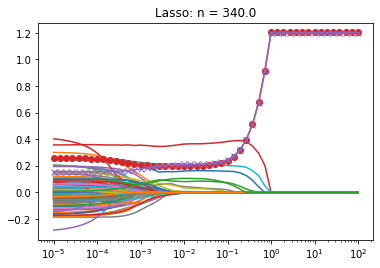

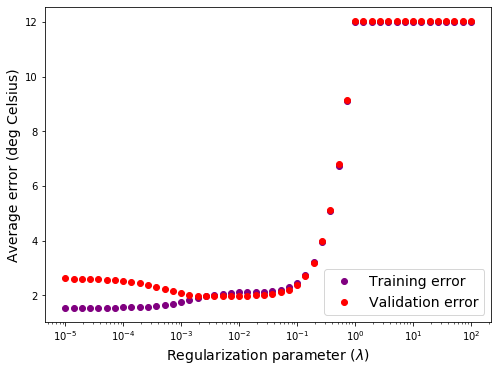

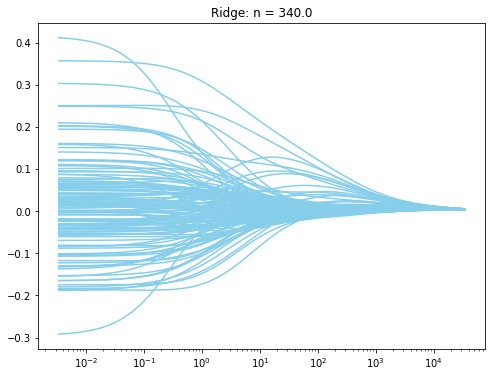

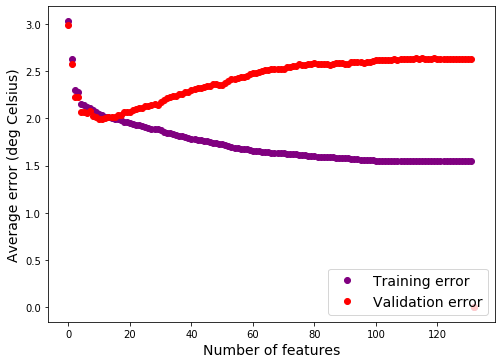

In [8]:
str_path = "./weather/"

load_files = False
if load_files:
    str_path_2015 = str_path + "hourly/2015/"
    data_matrix = create_data_matrix(str_path_2015)
    str_path_2016 = str_path + "hourly/2016/"
    data_matrix_2016 = create_data_matrix(str_path_2016)
else:
    data_matrix = np.load(str_path +"hourly_temperature_2015.npy")
    data_matrix_2016 = np.load(str_path +"hourly_temperature_2016.npy")

file_name_list = listdir(str_path + "hourly/2015/")
file_name_list.sort()


ind_response = 78 # 53 = Manhattan, 18 = Troy has 2 correlated features
# 23 = Williams dense linear model 30 = Death Valley 16 = AL_Talladega_10_NNE good for elastic net
# 78 = ND Jamestown also good for enet
print("Response is " + str(file_name_list[ind_response]))
y_raw = data_matrix[:,ind_response]
y_2016 = data_matrix_2016[:,ind_response]
ind_X = np.hstack((np.arange(0,ind_response),np.arange(ind_response+1,data_matrix.shape[1])))
X_raw = data_matrix[:,ind_X]
X_2016 = data_matrix_2016[:,ind_X]
n_features = X_raw.shape[1]

n_train_values = 40
n_test = int(1e3)
n_val = int(1e3)
n_train_max = data_matrix.shape[0] - n_test # 5e2
n_train_min = 133
n_train_list = np.around(np.logspace(np.log10(n_train_min),np.log10(n_train_max),n_train_values))
train_error_lasso_vec = []
val_error_lasso_vec = []
test_error_lasso_vec = []
test_2016_lasso_vec = []
train_error_ridge_vec = []
val_error_ridge_vec = []
test_error_ridge_vec = []
test_2016_ridge_vec = []

train_error_fsr_vec = []
val_error_fsr_vec = []
test_error_fsr_vec = []
test_2016_fsr_vec = []

coeffs_lasso_matrix = np.zeros((n_features,len(n_train_list)))
coeffs_ridge_matrix = np.zeros((n_features,len(n_train_list)))
coeffs_fsr_matrix = np.zeros((n_features,len(n_train_list)))
lambda_lasso_vec = []
lambda_ridge_vec = []
n_features_fsr_vec = []

n_lambda = 50
lambdas_ridge_aux = np.logspace(-5, 2, n_lambda)
lambdas_lasso = np.logspace(-5, 2, n_lambda)
eps = 1e-5  # the smaller it is the longer is the path
fixed_n = n_train_list[9]

i_m = 0
for n_train in n_train_list:
    lambdas_ridge = lambdas_ridge_aux * n_train
    aux_ind = np.random.permutation(range(data_matrix.shape[0]))
    ind_test = aux_ind[:n_test]
    ind_val = aux_ind[n_test:(n_test+n_val)]
    X_test = X_raw[ind_test,:]
    y_test = y_raw[ind_test]
    X_val = X_raw[ind_val,:]
    y_val = y_raw[ind_val]
    ind_train = aux_ind[(n_test+n_val):int(n_test+n_val+n_train)]
    X_train = X_raw[ind_train,:]
    y_train = y_raw[ind_train]
    
    center_vec = X_train.mean(axis=0)
    X_train_centered = X_train - center_vec
    col_norms = np.linalg.norm(X_train_centered, axis=0) / np.sqrt(n_train)
    X_train_norm = np.true_divide(X_train_centered, col_norms)
    X_test_centered = X_test - center_vec
    X_test_norm = np.true_divide(X_test_centered, col_norms)
    X_val_centered = X_val - center_vec
    X_val_norm = np.true_divide(X_val_centered, col_norms)
    X_2016_centered = X_2016 - center_vec
    X_2016_norm = np.true_divide(X_2016_centered, col_norms)
    y_train_center = y_train.mean()
    y_train_centered = y_train - y_train_center
    norm_y_train = np.linalg.norm(y_train_centered) / np.sqrt(n_train)
    y_train_norm = y_train_centered / norm_y_train
    
    print("Computing regularization path using the lasso...")
    lambdas_lasso, coeffs_lasso, _ = lasso_path(X_train_norm, y_train_norm, eps,  normalize=False,
                                          alphas = lambdas_lasso, fit_intercept=False)
    
    min_error_val = 1e4
    i_lambda = 0
    val_error_lasso_lambdas = np.zeros(n_lambda)
    train_error_lasso_lambdas = np.zeros(n_lambda)
    for i, coeffs_est in enumerate(coeffs_lasso.T):
        y_val_lasso = norm_y_train * np.dot(X_val_norm, coeffs_est) + y_train_center
        error_val = np.linalg.norm(y_val - y_val_lasso) / np.sqrt(len(y_val))
        # error_val_vec.append(error_val)
        if error_val < min_error_val:
            min_error_val = error_val
            lambda_best_lasso = lambdas_lasso[i]
            coeffs_lasso_best = coeffs_est
        y_train_lasso = norm_y_train * np.dot(X_train_norm, coeffs_est) + y_train_center
        train_error_lasso_lambdas[i] =  np.linalg.norm(y_train - y_train_lasso ) / np.sqrt(len(y_train))
        val_error_lasso_lambdas[i] = error_val
    lambda_lasso_vec.append(lambda_best_lasso)
    y_train_lasso = norm_y_train * np.dot(X_train_norm, coeffs_lasso_best) + y_train_center
    y_test_lasso = norm_y_train * np.dot(X_test_norm, coeffs_lasso_best) + y_train_center
    y_2016_lasso = norm_y_train * np.dot(X_2016_norm, coeffs_lasso_best) + y_train_center
    train_error_lasso = np.linalg.norm(y_train - y_train_lasso) / np.sqrt(len(y_train))
    test_error_lasso = np.linalg.norm(y_test - y_test_lasso) / np.sqrt(len(y_test))
    test_2016_lasso = np.linalg.norm(y_2016 - y_2016_lasso) / np.sqrt(len(y_2016))
    train_error_lasso_vec.append(train_error_lasso)
    val_error_lasso_vec.append(min_error_val)
    test_error_lasso_vec.append(test_error_lasso)
    test_2016_lasso_vec.append(test_2016_lasso)
    coeffs_lasso_matrix[:,i_m] = coeffs_lasso_best
    
    
    if n_train == fixed_n:
        coeffs_lasso_fixed = np.copy(coeffs_lasso)
        plt.figure()
        plt.plot(lambdas_lasso,coeffs_lasso.T)
        plt.plot(lambdas_lasso,val_error_lasso_lambdas/10.,marker='o')
        plt.plot(lambdas_lasso,train_error_lasso_lambdas/10.,marker='x')
        plt.xscale('log')
        plt.title('Lasso: n = ' + str(n_train))
        
        plt.figure(figsize=(8,6))
        plt.plot(lambdas_lasso,train_error_lasso_lambdas,marker='o',linestyle='none',color='purple',label='Training error')
        plt.plot(lambdas_lasso,val_error_lasso_lambdas,marker='o',linestyle='none',color='red',label='Validation error')
        plt.xlabel(r"Regularization parameter ($\lambda$)",fontsize=14)
        plt.ylabel('Average error (deg Celsius)',fontsize=14)
        plt.gcf().subplots_adjust(bottom=0.15)
        plt.xscale('log')
        plt.legend(loc = 'lower right',fontsize=14)
        
    
    # ridge regression
    clf = linear_model.Ridge(fit_intercept=False, normalize=False,)
    min_error_val = 1e3
    lambda_best = 0
    coeffs_ridge = np.zeros((n_features,n_lambda))
    val_error_ridge_lambdas = np.zeros(n_lambda)
    for ind_a,a in enumerate(lambdas_ridge):
        # print "lambda: " + str(a)
        clf.set_params(alpha=a)
        clf.fit(X_train_norm, y_train_norm)
        coeffs_ridge[:,ind_a] = clf.coef_
        y_val_ridge = norm_y_train * np.dot(X_val_norm, clf.coef_) + y_train_center
        error_val = np.linalg.norm(y_val - y_val_ridge) / np.sqrt(len(y_val))
        val_error_ridge_lambdas[ind_a] = error_val
        # error_val_vec.append(error_val)
        if error_val < min_error_val:
            min_error_val = error_val
            lambda_best = a
            coeffs_ridge_best = clf.coef_
    lambda_ridge_vec.append(lambda_best)
    y_train_ridge = norm_y_train * np.dot(X_train_norm, coeffs_ridge_best) + y_train_center
    y_test_ridge = norm_y_train * np.dot(X_test_norm, coeffs_ridge_best) + y_train_center
    y_2016_ridge = norm_y_train * np.dot(X_2016_norm, coeffs_ridge_best) + y_train_center
    train_error_ridge = np.linalg.norm(y_train - y_train_ridge) / np.sqrt(len(y_train))
    test_error_ridge = np.linalg.norm(y_test - y_test_ridge) / np.sqrt(len(y_test))
    test_2016_ridge = np.linalg.norm(y_2016 - y_2016_ridge) / np.sqrt(len(y_2016))
    train_error_ridge_vec.append(train_error_ridge)
    val_error_ridge_vec.append(min_error_val)
    test_error_ridge_vec.append(test_error_ridge)
    test_2016_ridge_vec.append(test_2016_ridge)
    coeffs_ridge_matrix[:,i_m] = coeffs_ridge_best
    
    if n_train == fixed_n:
        coeffs_ridge_fixed = np.copy(coeffs_ridge)
        plt.figure(figsize=(8,6))
        # plt.plot(lambdas_ridge,val_error_lasso_lambdas/10.,marker='o')
        for ind in range(n_features):
            plt.plot(lambdas_ridge,coeffs_ridge[ind,:],color='skyblue')
            plt.xscale('log')
            plt.title('Ridge: n = ' + str(n_train))
            
            
    # FSR
    min_error_val = 1e3
    n_features_best_fsr = 0
    n_feature = X_train_norm.shape[1]
    coeffs_fsr = np.zeros((X_train_norm.shape[1],X_train_norm.shape[1]))
    val_error_fsr_lambdas = np.zeros(n_feature)
    train_error_fsr_lambdas = np.zeros(n_feature)
    for i,a in enumerate(range(1,n_feature)):
        coeffs_fsr = FSR(X_train_norm,y_train_norm,num_features=a)
        y_train_fsr = norm_y_train * np.dot(X_train_norm, coeffs_fsr) + y_train_center
        y_val_fsr = norm_y_train * np.dot(X_val_norm, coeffs_fsr) + y_train_center
        error_val = np.linalg.norm(y_val - y_val_fsr) / np.sqrt(len(y_val))
    #         error_val_vec.append(error_val)
        if error_val < min_error_val:
            min_error_val = error_val
            n_features_best_fsr = a
            coeffs_fsr_best = coeffs_est

        train_error_fsr_lambdas[i] =  np.linalg.norm(y_train - y_train_fsr ) / np.sqrt(len(y_train))
        val_error_fsr_lambdas[i] = error_val
    n_features_fsr_vec.append(n_features_best_fsr)

    y_train_fsr = norm_y_train * np.dot(X_train_norm, coeffs_fsr_best) + y_train_center

    y_train_fsr = norm_y_train * np.dot(X_train_norm, coeffs_fsr_best) + y_train_center
    y_test_fsr = norm_y_train * np.dot(X_test_norm, coeffs_fsr_best) + y_train_center
    y_2016_fsr = norm_y_train * np.dot(X_2016_norm, coeffs_fsr_best) + y_train_center
    train_error_fsr = np.linalg.norm(y_train - y_train_fsr) / np.sqrt(len(y_train))
    test_error_fsr = np.linalg.norm(y_test - y_test_fsr) / np.sqrt(len(y_test))
    test_2016_fsr = np.linalg.norm(y_2016 - y_2016_fsr) / np.sqrt(len(y_2016))
    train_error_fsr_vec.append(train_error_fsr)
    val_error_fsr_vec.append(min_error_val)
    test_error_fsr_vec.append(test_error_fsr)
    test_2016_fsr_vec.append(test_2016_fsr)

    coeffs_fsr_matrix[:,i_m] = coeffs_fsr_best

    if n_train == fixed_n:
        plt.figure(figsize=(8,6))
        plt.plot(range(len(train_error_fsr_lambdas)),train_error_fsr_lambdas,marker='o',linestyle='none',color='purple',label='Training error')
        plt.plot(range(len(val_error_fsr_lambdas)),val_error_fsr_lambdas,marker='o',linestyle='none',color='red',label='Validation error')
        plt.xlabel(r"Number of features",fontsize=14)
        plt.ylabel('Average error (deg Celsius)',fontsize=14)
        plt.gcf().subplots_adjust(bottom=0.15)
        plt.legend(loc = 'lower right',fontsize=14)
            
    i_m = i_m + 1

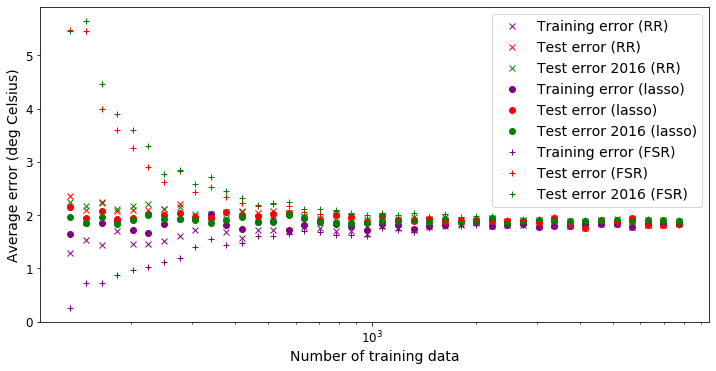

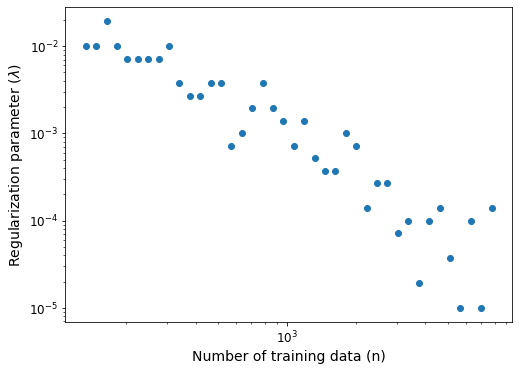

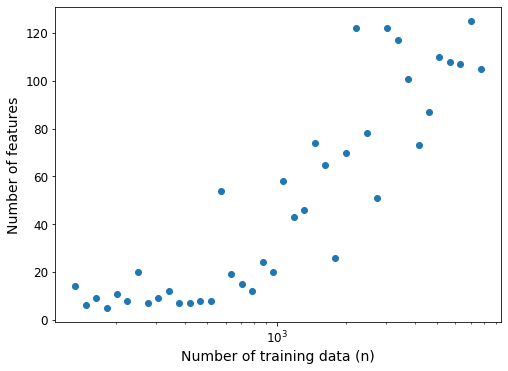

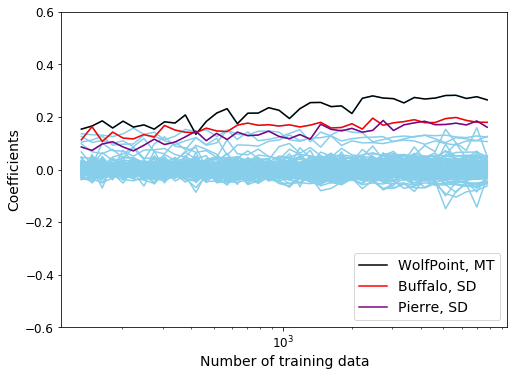

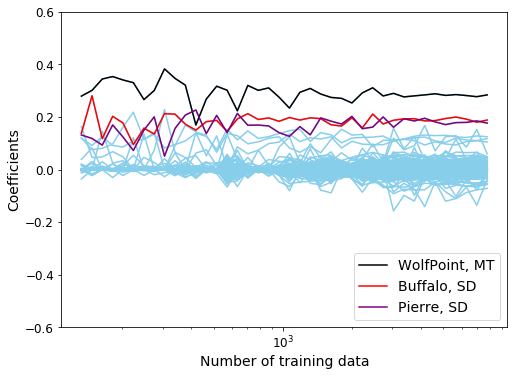

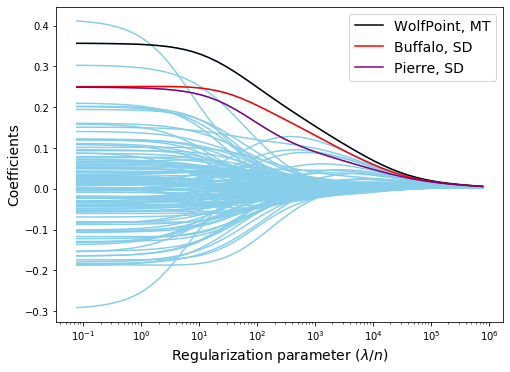

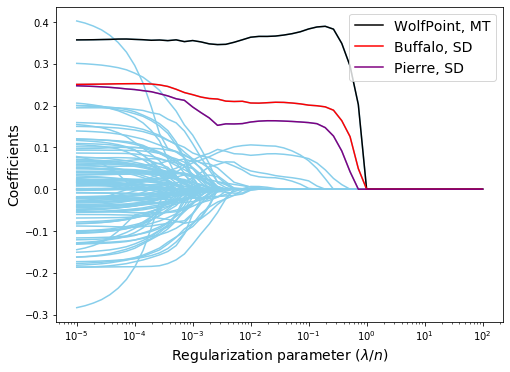

In [9]:

# xticks=(np.array([200,500,1000,2000,5000]))
# xtick_labels = ('200','500','1000','2000','5000')
plt.figure(figsize=(12,6))
linstyle = 'None'
plt.plot(n_train_list,train_error_ridge_vec,linestyle=linstyle,marker='x',color='purple',label="Training error (RR)")
plt.plot(n_train_list,test_error_ridge_vec,linestyle=linstyle,marker='x',color='red',label="Test error (RR)")
plt.plot(n_train_list,test_2016_ridge_vec,linestyle=linstyle,marker='x',color='green',label="Test error 2016 (RR)")
plt.plot(n_train_list,train_error_lasso_vec,linestyle=linstyle,marker='o',color='purple',label="Training error (lasso)")
plt.plot(n_train_list,test_error_lasso_vec,linestyle=linstyle,marker='o',color='red',label="Test error (lasso)")
plt.plot(n_train_list,test_2016_lasso_vec,linestyle=linstyle,marker='o',color='green',label="Test error 2016 (lasso)")
plt.plot(n_train_list,train_error_fsr_vec,linestyle=linstyle,marker='+',color='purple',label="Training error (FSR)")
plt.plot(n_train_list,test_error_fsr_vec,linestyle=linstyle,marker='+',color='red',label="Test error (FSR)")
plt.plot(n_train_list,test_2016_fsr_vec,linestyle=linstyle,marker='+',color='green',label="Test error 2016 (FSR)")
# plt.ylim((-0.5,7))
plt.xscale('log')
plt.xlabel('Number of training data',fontsize=14)
plt.ylabel('Average error (deg Celsius)',fontsize=14)
#plt.xticks(xticks,xtick_labels)
plt.tick_params(labelsize=12)
plt.legend(fontsize=14)
plt.gcf().subplots_adjust(bottom=0.15)

plt.figure(figsize=(8,6))
plt.plot(n_train_list,lambda_lasso_vec,marker='o',linestyle='none')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"Regularization parameter ($\lambda$)",fontsize=14)
plt.xlabel('Number of training data (n)',fontsize=14)
# plt.xticks(xticks,xtick_labels)
plt.tick_params(labelsize=12)
# plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(bottom=0.15)


plt.figure(figsize=(8,6))
plt.plot(n_train_list,n_features_fsr_vec,marker='o',linestyle='none')
plt.xscale('log')
#plt.yscale('log')
plt.ylabel(r"Number of features",fontsize=14)
plt.xlabel('Number of training data (n)',fontsize=14)
# plt.xticks(xticks,xtick_labels)
plt.tick_params(labelsize=12)
# plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(bottom=0.15)


n_largest = 3
color_list = ['black','red','purple','green','orange']
sorted_coeffs = np.argsort(np.abs(coeffs_ridge_matrix[:,-1]))
largest_coeffs = sorted_coeffs[-1:(-n_largest-1):-1]
plt.figure(figsize=(8,6))
for ind in range(n_features):
    plt.plot(n_train_list,coeffs_ridge_matrix[ind,:],color='skyblue')
for ind in range(len(largest_coeffs)):
    ind_name = largest_coeffs[ind]
    if ind_name>=ind_response:
        ind_name = ind_name + 1
    aux_name = file_name_list[ind_name]
    aux_name = aux_name[14:]
    aux_name = aux_name[:-7]
    table = str.maketrans(dict.fromkeys('_0123456789'))
    aux_name = aux_name.translate(table)
    aux_name = aux_name[2:] + ", " + aux_name[:2]
    plt.plot(n_train_list,coeffs_ridge_matrix[largest_coeffs[ind],:],color=color_list[ind],label=aux_name)
plt.ylim((-0.6,0.6))
plt.xscale('log')
plt.xlabel('Number of training data',fontsize=14)
plt.ylabel('Coefficients',fontsize=14)
# plt.xticks(xticks,xtick_labels)
plt.tick_params(labelsize=12)
# plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(bottom=0.15)
#plt.legend(loc = 'upper right',bbox_to_anchor=(1.3, 1.))
plt.legend(loc = 'lower right',fontsize=14)
aux_name = file_name_list[ind_response]
aux_name = aux_name[14:]
aux_name = aux_name[:-7]
table = str.maketrans(dict.fromkeys('_0123456789'))
aux_name = aux_name.translate(table)
aux_name = aux_name[2:] + ", " + aux_name[:2]
# plt.title(aux_name)

sorted_coeffs = np.argsort(np.abs(coeffs_lasso_matrix[:,-1]))
largest_coeffs = sorted_coeffs[-1:(-n_largest-1):-1]
plt.figure(figsize=(8,6))
for ind in range(n_features):
    plt.plot(n_train_list,coeffs_lasso_matrix[ind,:],color='skyblue')
for ind in range(len(largest_coeffs)):
    ind_name = largest_coeffs[ind]
    if ind_name>=ind_response:
        ind_name = ind_name + 1
    aux_name = file_name_list[ind_name]
    aux_name = aux_name[14:]
    aux_name = aux_name[:-7]
    table = str.maketrans(dict.fromkeys('_0123456789'))
    aux_name = aux_name.translate(table)
    aux_name = aux_name[2:] + ", " + aux_name[:2]
    plt.plot(n_train_list,coeffs_lasso_matrix[largest_coeffs[ind],:],color=color_list[ind],label=aux_name)
plt.ylim((-0.6,0.6))
plt.xscale('log')
plt.xlabel('Number of training data',fontsize=14)
plt.ylabel('Coefficients',fontsize=14)
# plt.xticks(xticks,xtick_labels)
plt.tick_params(labelsize=12)
# plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(bottom=0.15)
#plt.legend(loc = 'upper right',bbox_to_anchor=(1.3, 1.))
plt.legend(loc = 'lower right',fontsize=14)
aux_name = file_name_list[ind_response]
aux_name = aux_name[14:]
aux_name = aux_name[:-7]
table = str.maketrans(dict.fromkeys('_0123456789'))
aux_name = aux_name.translate(table)
aux_name = aux_name[2:] + ", " + aux_name[:2]
# plt.title(aux_name)

plt.figure(figsize=(8,6))
for ind in range(n_features):
    plt.plot(lambdas_ridge,coeffs_ridge_fixed[ind,:],color='skyblue')
    plt.xscale('log')
for ind in range(len(largest_coeffs)):
    ind_name = largest_coeffs[ind]
    if ind_name>=ind_response:
        ind_name = ind_name + 1
    aux_name = file_name_list[ind_name]
    aux_name = aux_name[14:]
    aux_name = aux_name[:-7]
    table = str.maketrans(dict.fromkeys('_0123456789'))
    aux_name = aux_name.translate(table)
    aux_name = aux_name[2:] + ", " + aux_name[:2]
    plt.plot(lambdas_ridge,coeffs_ridge_fixed[largest_coeffs[ind],:],color=color_list[ind],label=aux_name)
plt.xlabel(r"Regularization parameter ($\lambda/n$)",fontsize=14)
plt.ylabel('Coefficients',fontsize=14)
plt.gcf().subplots_adjust(bottom=0.15)
plt.legend(loc = 'upper right',fontsize=14)
plt.xscale('log')

plt.figure(figsize=(8,6))
for ind in range(n_features):
    plt.plot(lambdas_lasso,coeffs_lasso_fixed[ind,:],color='skyblue')
    plt.xscale('log')
for ind in range(len(largest_coeffs)):
    ind_name = largest_coeffs[ind]
    if ind_name>=ind_response:
        ind_name = ind_name + 1
    aux_name = file_name_list[ind_name]
    aux_name = aux_name[14:]
    aux_name = aux_name[:-7]
    table = str.maketrans(dict.fromkeys('_0123456789'))
    aux_name = aux_name.translate(table)
    aux_name = aux_name[2:] + ", " + aux_name[:2]
    plt.plot(lambdas_lasso,coeffs_lasso_fixed[largest_coeffs[ind],:],color=color_list[ind],label=aux_name)
plt.xlabel(r"Regularization parameter ($\lambda/n$)",fontsize=14)
plt.ylabel('Coefficients',fontsize=14)
plt.gcf().subplots_adjust(bottom=0.15)
plt.legend(loc = 'upper right',fontsize=14)
plt.xscale('log')